# Investigate dynamic height and ssh in relation to hydrographic and velocity features

## Imports

In [1]:
# Imports
from scipy import stats
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import copernicusmarine
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.signal import savgol_filter
import copernicusmarine
from geopy.distance import geodesic

fontsize=12

/Users/joegradone/anaconda3/envs/RU29_69W/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

In [2]:

def calc_segment_transport(ds):
    segment_dist = np.empty(len(ds.time))
    segment_dist[:] = np.nan
    segment_transport = np.empty(len(ds.time))
    segment_transport[:] = np.nan
    dz = np.diff(ds.depth)[0]

    for x in np.arange(0,len(ds.time)):
        segment_dist[x] = geodesic((ds.start_lat[x],ds.start_lon[x]),(ds.end_lat[x],ds.end_lon[x])).meters
        segment_transport[x] = np.nansum(ds.u_grid[:,x]*segment_dist[x]*dz)
    
    ds["segment_transport"] = (("time"), segment_transport)
    ds["segment_dist"] = (("time"), segment_dist)

    return ds





def match_ssh_to_glider(gridded_glider: xr.Dataset, ssh_ds: xr.Dataset) -> pd.DataFrame:
    """
    Matches the nearest SSH dataset (sla and adt) values in space and time to each time, latitude, and longitude point 
    in the glider dataset.
    
    Parameters:
    gridded_glider (xr.Dataset): Xarray dataset with latitude, longitude, and time.
    ssh_ds (xr.Dataset): Xarray dataset with latitude, longitude, time, and variables 'sla' and 'adt'.

    Returns:
    pd.DataFrame: A pandas DataFrame containing matched sla, adt, time, latitude, and longitude.
    """
    # Convert times to datetime64[ns]
    gridded_glider = gridded_glider.assign_coords(time=pd.to_datetime(gridded_glider.time))
    
    # Convert ssh_ds.time to datetime and set as index
    ssh_ds = ssh_ds.assign_coords(time=pd.to_datetime(ssh_ds.time))
    
    # Ensure ssh_ds.time is a proper pandas Index to avoid float issues
    ssh_ds["time"] = ("time", pd.DatetimeIndex(ssh_ds.time.values))

    # Sort by time to prevent selection issues
    ssh_ds = ssh_ds.sortby("time")

    # Handle missing times: Use nearest time and spatial index
    matched_sla = []
    matched_adt = []
    matched_times = []
    matched_lat = []
    matched_lon = []
    
    for t in np.arange(0,len(gridded_glider.time)):
        # Find the closest SSH time for this specific time
        time_diff = np.abs(ssh_ds.time.values - gridded_glider.time.values[t])
        closest_time_idx = np.argmin(time_diff)
        
        # For each latitude and longitude pair, find the closest spatial coordinates in SSH dataset
        # Find the closest latitude and longitude in SSH data (nearest-neighbor)
        lat_diff = np.abs(ssh_ds.latitude.values - gridded_glider.latitude.values[t])
        lon_diff = np.abs(ssh_ds.longitude.values - gridded_glider.longitude.values[t])
        closest_lat_idx = np.argmin(lat_diff)
        closest_lon_idx = np.argmin(lon_diff)
        
        # Append the matched values for sla and adt
        matched_sla.append(ssh_ds.sla.values[closest_time_idx, closest_lat_idx, closest_lon_idx])
        matched_adt.append(ssh_ds.adt.values[closest_time_idx, closest_lat_idx, closest_lon_idx])

        # Append the corresponding time, latitude, and longitude from the gridded glider dataset
        matched_times.append(gridded_glider.time.values[t])
        matched_lat.append(gridded_glider.latitude.values[t])
        matched_lon.append(gridded_glider.longitude.values[t])

    # Create a pandas DataFrame
    matched_df = pd.DataFrame({
        "matched_time": matched_times,
        "matched_lat": matched_lat,
        "matched_lon": matched_lon,
        "matched_sla": matched_sla,
        "matched_adt": matched_adt
    })

    return matched_df




def compute_geo_strf(ds,p_ref=0):
    SA = ds['absolute_salinity'].values
    CT = ds['conservative_temperature'].values
    depth = ds['depth'].values
    time = ds['time'].values

    if not np.all(np.diff(depth) > 0):
        raise ValueError("Depth coordinate must be strictly increasing")

    p = gsw.p_from_z(-depth, 15)

    geo_strf = gsw.geo_strf_dyn_height(SA, CT, p,p_ref)

    geo_strf_da = xr.DataArray(
        geo_strf,
        dims=('depth', 'time'),
        coords={'depth': depth, 'time': time},
        name='geo_strf',
        attrs={
            'units': 'm2/s2',
            'long_name': f'Geostrophic Streamfunction'
        }
    )

    # Make a copy of original dataset and add the new variable
    ds_new = ds.copy()
    ds_new['geo_strf'] = geo_strf_da

    return ds_new


def compute_dha(ds):
    geo_strf = ds['geo_strf'].values  # assumed shape (depth, time)
    depth = ds['depth'].values        # shape (depth,)
    lat = ds['latitude'].values       # shape (time,)

    # Create 2D depth and latitude grids
    Z, LAT = np.meshgrid(-depth, lat, indexing='ij')  # shape (depth, time)

    # Compute pressure and gravity over the grid
    p = gsw.p_from_z(Z, LAT)         # shape (depth, time)
    g = gsw.grav(LAT, p)             # shape (depth, time)

    dha = geo_strf / g           # Dynamic height anomaly in meters

    # Add back to dataset
    dha_da = xr.DataArray(
        dha,
        dims=('depth', 'time'),
        coords={
            'depth': ds['depth'],
            'time': ds['time']
        },
        attrs={'units': 'm', 'long_name': 'Dynamic Height Anomaly'}
    )

    ds_out = ds.copy()
    ds_out['dha'] = dha_da
    return ds_out


## Load AD2CP and Glider data

In [3]:
transect1_ds_interp = xr.open_dataset('../data/processed_nc/RU29_2024_Processed_AD2CP_Transect1_Interpolated.nc')
transect2_ds_interp = xr.open_dataset('../data/processed_nc/RU29_2024_Processed_AD2CP_Transect2_Interpolated.nc')
transect2_ds_interp['time'] = transect2_ds_interp['time'].where(
    transect2_ds_interp['time'] != np.datetime64('1970-01-01T00:00:00'),
    other=np.datetime64('NaT')
)
## total ad2cp
ds = xr.open_dataset('../data/processed_nc/RU29_2024_Processed_AD2CP.nc')
ds = calc_segment_transport(ds)

glider = xr.open_dataset('../data/processed_nc/RU29_2024_depth_gridded_glider.nc')
glider = compute_geo_strf(glider,p_ref=990)
glider = compute_dha(glider)

glider


<xarray.Dataset> Size: 108MB
Dimensions:                          (depth: 499, time: 1351)
Coordinates:
  * depth                            (depth) float64 4kB 1.0 3.0 ... 995.0 997.0
  * time                             (time) datetime64[ns] 11kB 2024-04-19T14...
    latitude                         (time) float64 11kB 17.78 17.78 ... 17.85
    longitude                        (time) float64 11kB ...
Data variables: (12/20)
    ctd_time                         (depth, time) float64 5MB ...
    ctd_time_counts                  (depth, time) int64 5MB ...
    conductivity                     (depth, time) float64 5MB ...
    conductivity_counts              (depth, time) int64 5MB ...
    temperature                      (depth, time) float64 5MB ...
    temperature_counts               (depth, time) int64 5MB ...
    ...                               ...
    rho                              (depth, time) float64 5MB ...
    rho_counts                       (depth, time) int64 5MB ...
    sigma                            (depth, time) float64 5MB ...
    sigma_counts                     (depth, time) int64 5MB ...
    geo_strf                         (depth, time) float64 5MB nan nan ... nan
    dha                              (depth, time) float64 5MB nan nan ... nan

## Subset

In [4]:
## Taken from RU29_ABC2DR_Analysis.ipynb
transect1_start_time = pd.to_datetime('2024-04-27T20:05:00Z').tz_localize(None) ## transect 1 start time
transect1_end_time = pd.to_datetime('2024-05-18T12:00:00Z').tz_localize(None) ## transect 1 end time
transect2_start_time = pd.to_datetime('2024-05-18T12:00:00Z').tz_localize(None) ## transect 2 start time
transect2_end_time = pd.to_datetime('2024-06-06T00:00:00Z').tz_localize(None) ## transect 2 end time

eddy_ds = ds.sel(time=slice(transect2_end_time,None))

#glider = glider.sel(time=slice(transect1_start_time,transect2_end_time))



## SLA

In [5]:

ssh_ds = copernicusmarine.open_dataset(
  dataset_id="cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D",
  variables=["adt", "err_sla", "sla"],
  minimum_longitude=-90,
  maximum_longitude=-50,
  minimum_latitude=5,
  maximum_latitude=25,
  start_datetime="2024-04-15T00:00:00",
  end_datetime="2024-07-30T00:00:00",
)

glider_sla = match_ssh_to_glider(glider, ssh_ds)

glider_sla


INFO - 2025-11-14T20:33:45Z - Selected dataset version: "202311"
INFO - 2025-11-14T20:33:45Z - Selected dataset part: "default"


,matched_time,matched_lat,matched_lon,matched_sla,matched_adt
0,2024-04-19 14:23:50.975585938,17.779364,-67.057679,0.0059,0.6493
1,2024-04-19 14:46:53.984710693,17.779726,-67.059626,0.0059,0.6493
2,2024-04-19 14:46:57.983344555,17.779757,-67.059646,0.0059,0.6493
3,2024-04-19 16:16:42.972869873,17.778567,-67.072741,0.0059,0.6493
4,2024-04-19 16:16:44.978149414,17.778461,-67.072649,0.0059,0.6493
...,...,...,...,...,...
1346,2024-07-23 09:40:25.931915283,17.849849,-67.035178,0.0805,0.7239
1347,2024-07-23 09:40:27.925964355,17.849909,-67.035160,0.0805,0.7239
1348,2024-07-23 10:35:30.925628662,17.849774,-67.035532,0.0805,0.7239
1349,2024-07-23 10:35:32.923346996,17.849793,-67.035542,0.0805,0.7239


## Plots!

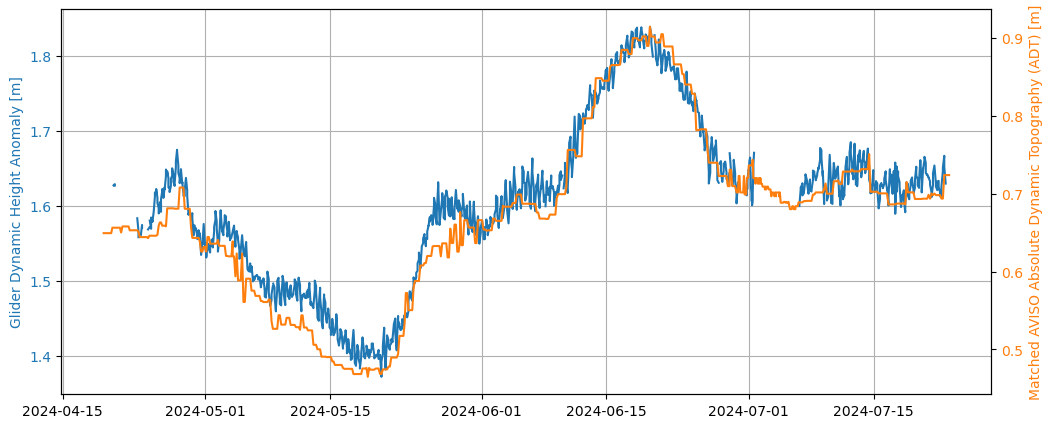

In [6]:
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(glider.time,glider.dha.isel(depth=1),color='tab:blue')
ax1.set_ylabel("Glider Dynamic Height Anomaly [m]",color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()

ax2.plot(glider_sla.matched_time,glider_sla.matched_adt,color='tab:orange')
ax2.set_ylabel("Matched AVISO Absolute Dynamic Topography (ADT) [m]",color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax1.grid()


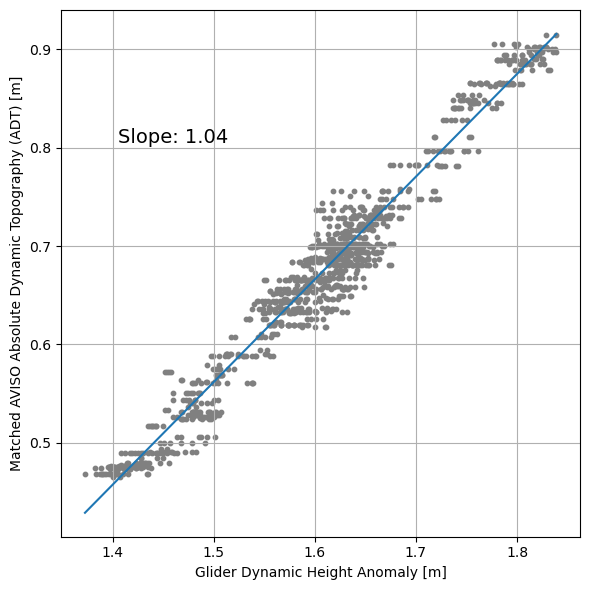

In [7]:
# Interpolate SHA (glider.dha) to matched ADT times
dha_matched = glider.dha.isel(depth=1).sortby('time').interp(time=glider_sla.sort_values(by='matched_time').matched_time)


# Get matched ADT values
adt_sorted = glider_sla.sort_values(by='matched_time').matched_adt

sla_sorted = glider_sla.sort_values(by='matched_time').matched_sla

# Extract values and clean NaNs
x = dha_matched.values
y = adt_sorted.values

mask = np.isfinite(x) & np.isfinite(y)
x_clean = x[mask]
y_clean = y[mask]

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(x_clean, y_clean, color='grey',s=10)
x_fit = np.linspace(x_clean.min(), x_clean.max(), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='tab:blue')

plt.text(1.405,0.805,f"Slope: {slope:.2f}",fontsize=14)


# Labels and layout
plt.xlabel("Glider Dynamic Height Anomaly [m]")
plt.ylabel("Matched AVISO Absolute Dynamic Topography (ADT) [m]")
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
transect1_smoothed_transport = transect1_ds_interp.segment_transport.copy()
transect1_smoothed_transport.values = savgol_filter(transect1_smoothed_transport.values, window_length=48, polyorder=2)

transect2_smoothed_transport = transect2_ds_interp.segment_transport.copy()
transect2_smoothed_transport.values = savgol_filter(transect2_smoothed_transport.values, window_length=48, polyorder=2)


transect1_glider = glider.sel(time=slice(transect1_start_time,transect1_end_time))
transect2_glider = glider.sel(time=slice(transect2_start_time,transect2_end_time))

transect1_smoothed_dha = transect1_glider.dha.isel(depth=1).copy()
transect1_smoothed_dha.values = savgol_filter(transect1_smoothed_dha.values, window_length=4, polyorder=2)
transect2_smoothed_dha = transect2_glider.dha.isel(depth=1).copy()
transect2_smoothed_dha.values = savgol_filter(transect2_smoothed_dha.values, window_length=4, polyorder=2)




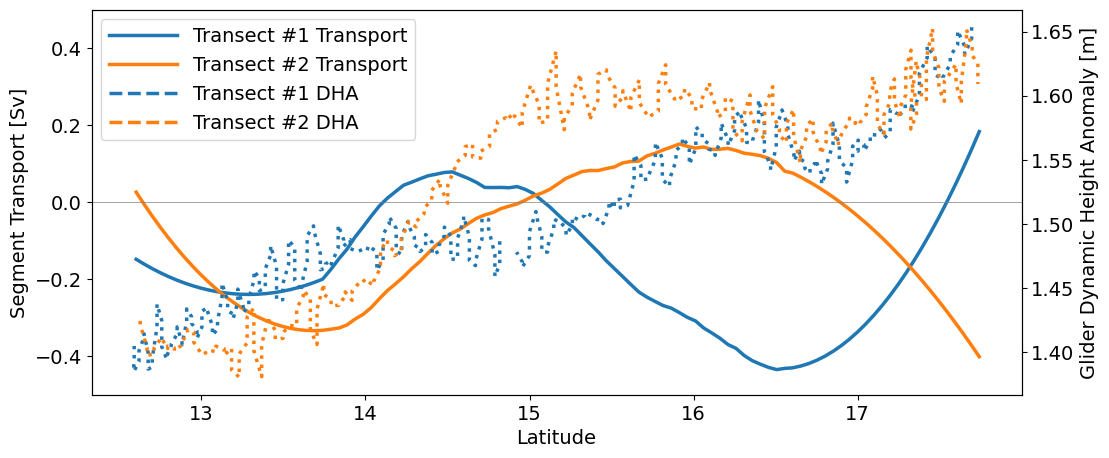

In [44]:
from matplotlib.lines import Line2D

fontsize = 14

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(transect1_ds_interp.latitude, transect1_smoothed_transport/1e6,
         linewidth=2.5, color='tab:blue')
ax1.plot(transect2_ds_interp.latitude, transect2_smoothed_transport/1e6,
         linewidth=2.5, color='tab:orange')

ax1.set_ylabel("Segment Transport [Sv]", fontsize=fontsize)
ax1.tick_params(axis='y', labelsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)
ax1.axhline(0, color='grey', linewidth=0.5)
ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel("Latitude", fontsize=fontsize)

solid1 = Line2D([], [], color='tab:blue', linewidth=2.5, label='Transect #1 Transport')
solid2 = Line2D([], [], color='tab:orange', linewidth=2.5, label='Transect #2 Transport')
dashed1 = Line2D([], [], color='tab:blue', linewidth=2.5, linestyle='--', label='Transect #1 DHA')
dashed2 = Line2D([], [], color='tab:orange', linewidth=2.5, linestyle='--', label='Transect #2 DHA')

ax1.legend(handles=[solid1, solid2, dashed1, dashed2], handlelength=3.5, fontsize=fontsize, loc='upper left')

ax2 = ax1.twinx()
ax2.plot(transect1_glider.latitude, transect1_smoothed_dha, ':',
         linewidth=2.5, color='tab:blue')
ax2.plot(transect2_glider.latitude, transect2_smoothed_dha, ':',
         linewidth=2.5, color='tab:orange')
ax2.set_ylabel("Glider Dynamic Height Anomaly [m]", fontsize=fontsize)
ax2.tick_params(axis='y', labelsize=fontsize)

plt.savefig('../figures/RU29_2024_ABC2DR_Segment_Transport_Glider_Dynamic_Height_Anom_by_Transect.png',
            bbox_inches='tight', dpi=300, facecolor='white')

plt.savefig('../figures/RU29_2024_ABC2DR_Segment_Transport_Glider_Dynamic_Height_Anom_by_Transect.png',bbox_inches='tight',dpi=300,facecolor='white')



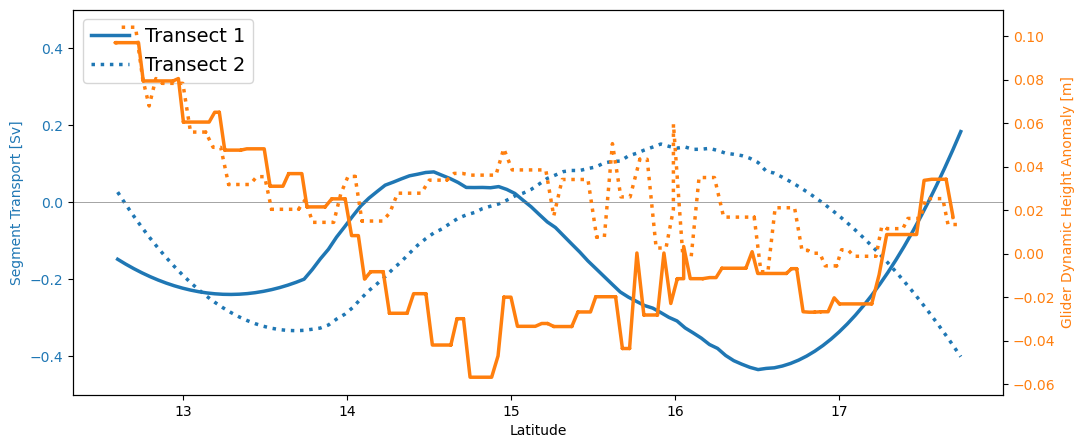

In [10]:
transect1_sla = glider_sla[
    (glider_sla['matched_time'] >= transect1_start_time) & 
    (glider_sla['matched_time'] <= transect1_end_time)
]


transect2_sla = glider_sla[
    (glider_sla['matched_time'] >= transect2_start_time) & 
    (glider_sla['matched_time'] <= transect2_end_time)
]

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(transect1_ds_interp.latitude,transect1_smoothed_transport/1e6,linewidth=2.5,color='tab:blue', label='Transect 1')
ax1.plot(transect2_ds_interp.latitude,transect2_smoothed_transport/1e6,':',linewidth=2.5,color='tab:blue',label='Transect 2')
# ax1.plot(transect1_ds_interp.latitude, transect1_ds_interp.segment_transport/ 1e6, color='tab:blue',alpha=0.5)
# ax1.plot(transect2_ds_interp.latitude, transect2_ds_interp.segment_transport/ 1e6, '--', color='tab:blue',alpha=0.5)
ax1.set_ylabel("Segment Transport [Sv]",color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.axhline(0,color='grey',linewidth=0.5)
ax1.set_ylim(-0.5,0.5)
ax1.set_xlabel("Latitude")
ax1.legend(loc='upper left', fontsize=fontsize)


ax2 = ax1.twinx()
ax2.plot(transect1_sla.matched_lat,transect1_sla.matched_sla,linewidth=2.5,color='tab:orange')
ax2.plot(transect2_sla.matched_lat,transect2_sla.matched_sla,':',linewidth=2.5,color='tab:orange')
ax2.set_ylabel("Glider Dynamic Height Anomaly [m]",color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')




## Subset a ssh time series for plotting

In [11]:
ssh69 = ssh_ds.isel(longitude=slice(83,85)).mean(dim='longitude')


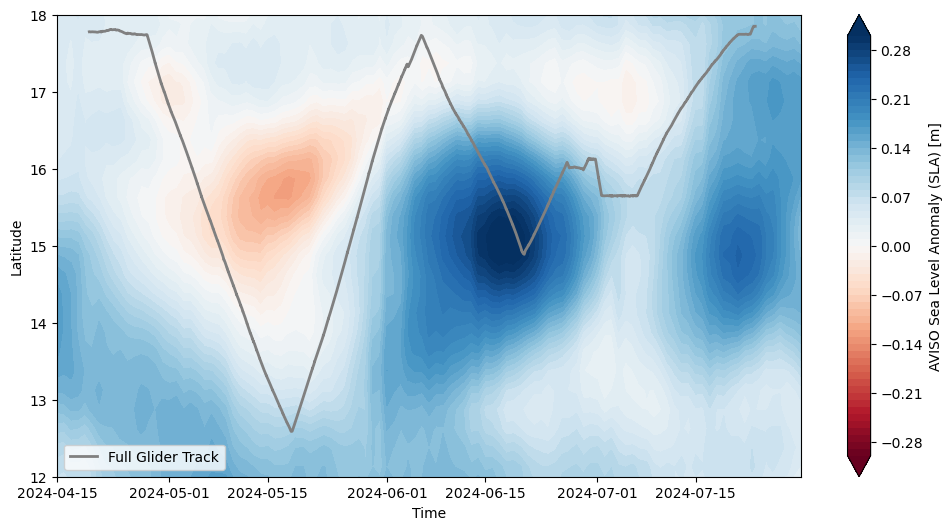

In [12]:
plt.figure(figsize=(12,6))
plt.contourf(ssh69.time, ssh69.latitude, ssh69.sla.transpose(),cmap='RdBu',levels=np.arange(-0.3,0.31,0.01),extend='both')
plt.colorbar(label='AVISO Sea Level Anomaly (SLA) [m]')

step = 15
plt.plot(glider.time, glider.latitude,linewidth=2,color='grey',zorder=2,label='Full Glider Track')
# plt.scatter(transect1_glider.time[::step], transect1_glider.latitude[::step],marker='*',s=100,zorder=3,label='Transect 1')
# plt.scatter(transect2_glider.time[::step], transect2_glider.latitude[::step],marker='^',s=100,zorder=3,label='Transect 2')

plt.xlabel('Time')
plt.ylabel('Latitude')
plt.ylim(12,18)
plt.legend()

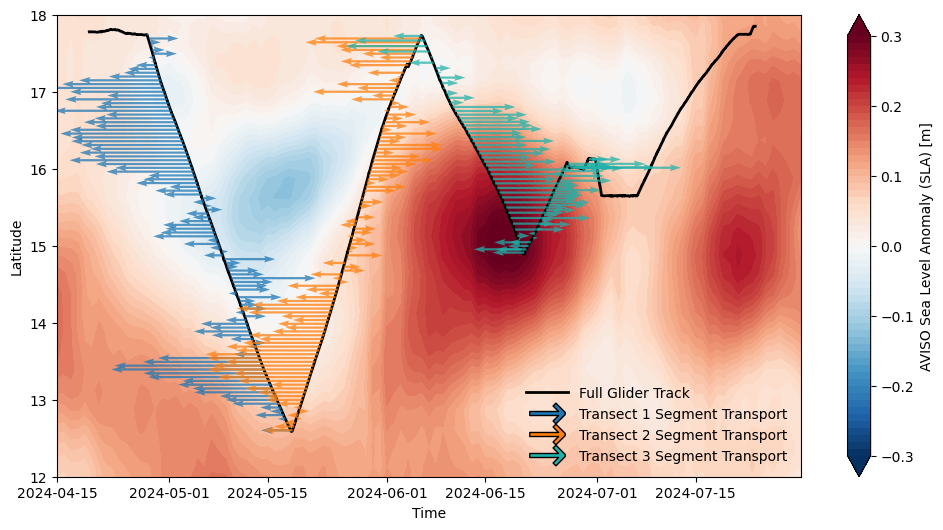

In [37]:
plt.figure(figsize=(12,6))
plt.contourf(ssh69.time, ssh69.latitude, ssh69.sla.transpose(),cmap='RdBu_r',levels=np.arange(-0.3,0.31,0.01),extend='both')
cb = plt.colorbar(label='AVISO Sea Level Anomaly (SLA) [m]')
cb.set_ticks(np.arange(-0.3, 0.31, 0.1))  # or finer: 0.05


plt.plot(glider.time, glider.latitude,linewidth=2,color='black',zorder=1,label='Full Glider Track')


# Normalize magnitude for quiver scaling
scale_factor = 10**(6.5)  # adjust as needed for visual scaling

# Transect 1: Horizontal transport arrows
plt.quiver(
    transect1_ds_interp.time.values,
    transect1_ds_interp.latitude.values,
    transect1_ds_interp.segment_transport.values / scale_factor,  # x-component (horizontal)
    np.zeros_like(transect1_ds_interp.segment_transport.values),  # y-component (no vertical)
    color='tab:blue',
    scale=1,
    width=0.003,
    headwidth=3,
    alpha=0.75,
    label='Transect 1 Transport'
)

# Transect 2: Horizontal transport arrows
plt.quiver(
    transect2_ds_interp.time.values,
    transect2_ds_interp.latitude.values,
    transect2_ds_interp.segment_transport.values / scale_factor,
    np.zeros_like(transect2_ds_interp.segment_transport.values),
    color='tab:orange',
    scale=1,
    width=0.003,
    headwidth=3,
    alpha=0.75,
    label='Transect 2 Transport'
)



# Transect 2: Horizontal transport arrows
plt.quiver(
    eddy_ds.time.values[::2],
    eddy_ds.latitude.values[::2],
    eddy_ds.segment_transport.values[::2] / scale_factor,
    np.zeros_like(eddy_ds.segment_transport.values[::2]),
    color='lightseagreen',
    scale=1,
    width=0.003,
    headwidth=3,
    alpha=0.75,
    label='Full Glider Track Transport'
)




plt.xlabel('Time')
plt.ylabel('Latitude')
plt.ylim(12,18)


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='Full Glider Track'),
    Line2D([0], [0], color='tab:blue',markeredgecolor="black", marker=r'$\rightarrow$', linestyle='None',
           markersize=17, label='Transect 1 Segment Transport'),
    Line2D([0], [0], color='tab:orange',markeredgecolor="black", marker=r'$\rightarrow$', linestyle='None',
           markersize=17, label='Transect 2 Segment Transport'),
    Line2D([0], [0], color='lightseagreen',markeredgecolor="black", marker=r'$\rightarrow$', linestyle='None',
            markersize=17, label='Transect 3 Segment Transport')
]

plt.legend(
    handles=legend_elements,
    loc='lower right',
    frameon=False,
    fontsize=10,
    markerscale=1.5,
    handlelength=3,
    borderpad=0.5
)

plt.xlim(pd.to_datetime('2024-04-15T00:00:00'), pd.to_datetime('2024-07-30T00:00:00'))

plt.savefig('../figures/RU29_2024_ABC2DR_AVISO_SLA_Hovmoller_Glider_Track_and_Segment_Transport.png',dpi=300,facecolor='white',bbox_inches='tight')


In [16]:
?plt.quiver

Signature: plt.quiver(*args, data=None, **kwargs) -> 'Quiver'
Docstring:
Plot a 2D field of arrows.

Call signature::

  quiver([X, Y], U, V, [C], /, **kwargs)

*X*, *Y* define the arrow locations, *U*, *V* define the arrow directions, and
*C* optionally sets the color. The arguments *X*, *Y*, *U*, *V*, *C* are
positional-only.

**Arrow length**

The default settings auto-scales the length of the arrows to a reasonable size.
To change this behavior see the *scale* and *scale_units* parameters.

**Arrow shape**

The arrow shape is determined by *width*, *headwidth*, *headlength* and
*headaxislength*. See the notes below.

**Arrow styling**

Each arrow is internally represented by a filled polygon with a default edge
linewidth of 0. As a result, an arrow is rather a filled area, not a line with
a head, and `.PolyCollection` properties like *linewidth*, *edgecolor*,
*facecolor*, etc. act accordingly.


Parameters
----------
X, Y : 1D or 2D array-like, optional
    The x and y coordinates 